# Overview
This is **not** a strategy-edge study. This is a **constraint-satisfaction + worst-case portfolio construction** problem. We are finding scaling factor $s_1$, $s_2$ such that the combined equity process respects **daily** and **total** drawdown constraints with high confidence.

In [118]:
### 0. Parameters

# Construct portfolio
STARTING_CAPITAL = 80000
WEIGHT_Z6 = 0.1
WEIGHT_Z7 = 0.4

In [119]:
### 1. Imports, loading and normalizing the data
import pandas as pd
import numpy as np

# Loading data
df_z6 = pd.read_csv('C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\research\\ftmo\\data\\Z6+_pnl.csv')
df_z7 = pd.read_csv('C:\\Users\\blazo\\Documents\\Misc\\QJ\\quant-journey\\research\\ftmo\\data\\Z7_pnl.csv')

# Convert Date to datetime
df_z6['Date'] = pd.to_datetime(df_z6['Date'])
df_z7['Date'] = pd.to_datetime(df_z7['Date'])

# Convert PnL to Equity (starting equity = 10000)
df_z6['Equity'] = 10000 + df_z6['PnL']
df_z7['Equity'] = 10000 + df_z7['PnL']

# Convert Equity to Returns
df_z6['Returns'] = df_z6['Equity'].pct_change()
df_z7['Returns'] = df_z7['Equity'].pct_change()

In [120]:
### 2. Individual strategy risk diagnostics

# Helper functions for cleaner code
def calculate_drawdown_metrics(df):
    """Calculate drawdown metrics for a strategy dataframe."""
    df['Peak'] = df['Equity'].cummax()
    df['Drawdown'] = ((df['Equity'] - df['Peak']) / df['Peak']) * 100
    
    max_dd = df['Drawdown'].min()
    max_dd_idx = df['Drawdown'].idxmin()
    peak_idx = df.loc[:max_dd_idx, 'Peak'].idxmax()
    
    start_date = df.loc[peak_idx, 'Date']
    trough_date = df.loc[max_dd_idx, 'Date']
    
    # Find recovery date
    recovery_idx = df[(df.index > max_dd_idx) & 
                      (df['Equity'] >= df.loc[peak_idx, 'Peak'])].index
    end_date = df.loc[recovery_idx[0], 'Date'] if len(recovery_idx) > 0 else df.iloc[-1]['Date']
    
    return {
        'max_dd': max_dd,
        'start_date': start_date,
        'trough_date': trough_date,
        'end_date': end_date,
        'days_to_trough': (trough_date - start_date).days,
        'days_total': (end_date - start_date).days
    }

def calculate_daily_loss_metrics(df):
    """Calculate maximum daily loss metrics for a strategy dataframe."""
    worst_day_idx = df['Returns'].idxmin()
    worst_day_return = df['Returns'].min() * 100
    
    return {
        'worst_return': worst_day_return,
        'date': df.loc[worst_day_idx, 'Date'],
        'equity_before': df.loc[worst_day_idx - 1, 'Equity'],
        'equity_loss': df.loc[worst_day_idx, 'Equity'] - df.loc[worst_day_idx - 1, 'Equity']
    }

def calculate_volatility_metrics(df):
    """Calculate volatility metrics for a strategy dataframe."""
    std_dev = df['Returns'].std() * 100
    negative_returns = df[df['Returns'] < 0]['Returns']
    downside_dev = negative_returns.std() * 100
    
    return {
        'std_dev': std_dev,
        'downside_dev': downside_dev,
        'negative_days': len(negative_returns)
    }

def analyze_losing_streaks(df):
    """Analyze consecutive losing days (negative returns)."""
    losing_days = df['Returns'] < 0
    streaks = []
    current_streak = 0
    
    for is_losing in losing_days:
        if is_losing:
            current_streak += 1
        else:
            if current_streak > 0:
                streaks.append(current_streak)
            current_streak = 0
    
    if current_streak > 0:
        streaks.append(current_streak)
    
    if len(streaks) > 0:
        return {
            'total_streaks': len(streaks),
            'mean': np.mean(streaks),
            'median': np.median(streaks),
            'percentile_90': np.percentile(streaks, 90),
            'max': max(streaks),
            'streaks': streaks
        }
    else:
        return {
            'total_streaks': 0,
            'mean': 0,
            'median': 0,
            'percentile_90': 0,
            'max': 0,
            'streaks': []
        }

def print_section_header(title):
    """Print a formatted section header."""
    print("\n" + "=" * 70)
    print(f"  {title}")
    print("=" * 70)

def print_strategy_metrics(strategy_name, metrics_dict):
    """Print metrics in a clean, formatted way."""
    print(f"\n{strategy_name}:")
    print("-" * 70)
    for key, value in metrics_dict.items():
        print(f"  {key:.<50} {value}")

# ============================================================================
# 2.1. Maximum Drawdown Analysis
# ============================================================================
print_section_header("2.1. MAXIMUM DRAWDOWN ANALYSIS")

z6_dd = calculate_drawdown_metrics(df_z6)
z7_dd = calculate_drawdown_metrics(df_z7)

print_strategy_metrics("Z6", {
    "Maximum Drawdown": f"{z6_dd['max_dd']:.2f}%",
    "Peak Date": z6_dd['start_date'].strftime('%Y-%m-%d'),
    "Trough Date": z6_dd['trough_date'].strftime('%Y-%m-%d'),
    "Recovery Date": z6_dd['end_date'].strftime('%Y-%m-%d'),
    "Days to Trough": z6_dd['days_to_trough'],
    "Total Duration (days)": z6_dd['days_total']
})

print_strategy_metrics("Z7", {
    "Maximum Drawdown": f"{z7_dd['max_dd']:.2f}%",
    "Peak Date": z7_dd['start_date'].strftime('%Y-%m-%d'),
    "Trough Date": z7_dd['trough_date'].strftime('%Y-%m-%d'),
    "Recovery Date": z7_dd['end_date'].strftime('%Y-%m-%d'),
    "Days to Trough": z7_dd['days_to_trough'],
    "Total Duration (days)": z7_dd['days_total']
})

# ============================================================================
# 2.2. Maximum Daily Loss Analysis
# ============================================================================
print_section_header("2.2. MAXIMUM DAILY LOSS ANALYSIS")

z6_loss = calculate_daily_loss_metrics(df_z6)
z7_loss = calculate_daily_loss_metrics(df_z7)

print_strategy_metrics("Z6", {
    "Worst Single-Day Return": f"{z6_loss['worst_return']:.2f}%",
    "Date": z6_loss['date'].strftime('%Y-%m-%d'),
    "Equity Before": f"${z6_loss['equity_before']:,.2f}",
    "Equity Loss": f"${z6_loss['equity_loss']:,.2f}"
})

print_strategy_metrics("Z7", {
    "Worst Single-Day Return": f"{z7_loss['worst_return']:.2f}%",
    "Date": z7_loss['date'].strftime('%Y-%m-%d'),
    "Equity Before": f"${z7_loss['equity_before']:,.2f}",
    "Equity Loss": f"${z7_loss['equity_loss']:,.2f}"
})

# ============================================================================
# 2.3. Volatility Analysis
# ============================================================================
print_section_header("2.3. VOLATILITY ANALYSIS")

z6_vol = calculate_volatility_metrics(df_z6)
z7_vol = calculate_volatility_metrics(df_z7)

print_strategy_metrics("Z6", {
    "Standard Deviation (Daily Returns)": f"{z6_vol['std_dev']:.2f}%",
    "Downside Deviation": f"{z6_vol['downside_dev']:.2f}%",
    "Number of Negative Days": z6_vol['negative_days']
})

print_strategy_metrics("Z7", {
    "Standard Deviation (Daily Returns)": f"{z7_vol['std_dev']:.2f}%",
    "Downside Deviation": f"{z7_vol['downside_dev']:.2f}%",
    "Number of Negative Days": z7_vol['negative_days']
})

# ============================================================================
# 2.4. Losing Streak Analysis
# ============================================================================
print_section_header("2.4. LOSING STREAK ANALYSIS")

z6_streaks = analyze_losing_streaks(df_z6)
z7_streaks = analyze_losing_streaks(df_z7)

# Print Z6 streak metrics
print_strategy_metrics("Z6", {
    "Total Number of Losing Streaks": z6_streaks['total_streaks'],
    "Mean Losing Streak": f"{z6_streaks['mean']:.2f} days",
    "Median Losing Streak": f"{z6_streaks['median']:.0f} days",
    "90th Percentile": f"{z6_streaks['percentile_90']:.0f} days",
    "Maximum Streak": f"{z6_streaks['max']} days"
})

# Print Z6 distribution
if z6_streaks['streaks']:
    print("\n  Streak Distribution (Z6):")
    unique_lengths = sorted(set(z6_streaks['streaks']))
    for length in unique_lengths[:10]:
        count = z6_streaks['streaks'].count(length)
        percentage = (count / z6_streaks['total_streaks']) * 100
        print(f"    {length} day(s): {count:>3} occurrences ({percentage:>5.1f}%)")
    if len(unique_lengths) > 10:
        print(f"    ... and {len(unique_lengths) - 10} more unique streak lengths")

# Print Z7 streak metrics
print_strategy_metrics("Z7", {
    "Total Number of Losing Streaks": z7_streaks['total_streaks'],
    "Mean Losing Streak": f"{z7_streaks['mean']:.2f} days",
    "Median Losing Streak": f"{z7_streaks['median']:.0f} days",
    "90th Percentile": f"{z7_streaks['percentile_90']:.0f} days",
    "Maximum Streak": f"{z7_streaks['max']} days"
})

# Print Z7 distribution
if z7_streaks['streaks']:
    print("\n  Streak Distribution (Z7):")
    unique_lengths = sorted(set(z7_streaks['streaks']))
    for length in unique_lengths[:10]:
        count = z7_streaks['streaks'].count(length)
        percentage = (count / z7_streaks['total_streaks']) * 100
        print(f"    {length} day(s): {count:>3} occurrences ({percentage:>5.1f}%)")
    if len(unique_lengths) > 10:
        print(f"    ... and {len(unique_lengths) - 10} more unique streak lengths")

print("\n" + "=" * 70)


  2.1. MAXIMUM DRAWDOWN ANALYSIS

Z6:
----------------------------------------------------------------------
  Maximum Drawdown.................................. -32.55%
  Peak Date......................................... 2018-03-08
  Trough Date....................................... 2018-03-25
  Recovery Date..................................... 2018-07-08
  Days to Trough.................................... 17
  Total Duration (days)............................. 122

Z7:
----------------------------------------------------------------------
  Maximum Drawdown.................................. -20.55%
  Peak Date......................................... 2011-10-30
  Trough Date....................................... 2011-11-02
  Recovery Date..................................... 2011-11-14
  Days to Trough.................................... 3
  Total Duration (days)............................. 15

  2.2. MAXIMUM DAILY LOSS ANALYSIS

Z6:
-------------------------------------------

Z6+ exhibits deep **drawdowns (max -32.6%)** driven primarily by multi-day loss clustering rather than isolated shocks, with a **worst day of -22.97%**. While the median losing streak is one day, 90% of loss sequences last no longer than three days, with rare tail events extending to seven consecutive days.

Z7 displays a smaller maximum **drawdown (-20.6%)**, with a **worst day of -15.32%**, and lower return volatility, but features heavier loss-clustering tails, with rare streaks extending up to ten consecutive trading days, despite a median losing streak of one day.

In [121]:
### 3. Cross-strategy correlation and dependence analysis

# ============================================================================
# 3.1. Data Alignment
# ============================================================================

def align_strategy_returns(df1, df2):
    """Align two strategy dataframes by date and prepare for correlation analysis."""
    df_merged = pd.merge(
        df1[['Date', 'Returns']], 
        df2[['Date', 'Returns']], 
        on='Date', 
        how='inner', 
        suffixes=('_z6', '_z7')
    )
    df_merged.rename(columns={'Returns_z6': 'r_z6', 'Returns_z7': 'r_z7'}, inplace=True)
    df_merged.dropna(inplace=True)
    return df_merged

df_aligned = align_strategy_returns(df_z6, df_z7)

# ============================================================================
# 3.2. Return Correlation Analysis
# ============================================================================

def calculate_correlation_metrics(df_aligned):
    """Calculate various correlation metrics between strategies."""
    overall = df_aligned['r_z6'].corr(df_aligned['r_z7'])
    
    both_negative = df_aligned[(df_aligned['r_z6'] < 0) & (df_aligned['r_z7'] < 0)]
    stress = both_negative['r_z6'].corr(both_negative['r_z7']) if len(both_negative) > 0 else np.nan
    
    either_negative = df_aligned[(df_aligned['r_z6'] < 0) | (df_aligned['r_z7'] < 0)]
    semi_stress = either_negative['r_z6'].corr(either_negative['r_z7']) if len(either_negative) > 0 else np.nan
    
    return {
        'overall': overall,
        'stress': stress,
        'semi_stress': semi_stress,
        'total_days': len(df_aligned),
        'both_negative_days': len(both_negative),
        'either_negative_days': len(either_negative)
    }

print_section_header("3.2. RETURN CORRELATION ANALYSIS")

corr_metrics = calculate_correlation_metrics(df_aligned)

print_strategy_metrics("Correlation Metrics", {
    "Overall Pearson Correlation": f"{corr_metrics['overall']:.4f}",
    "Sample Size (Total Days)": f"{corr_metrics['total_days']:,}",
    "": "",
    "Stress Correlation (Both Negative)": f"{corr_metrics['stress']:.4f}",
    "Stress Sample Size": f"{corr_metrics['both_negative_days']:,} days",
    " ": "",
    "Semi-Stress Correlation (Either Negative)": f"{corr_metrics['semi_stress']:.4f}",
    "Semi-Stress Sample Size": f"{corr_metrics['either_negative_days']:,} days"
})

# ============================================================================
# 3.3. Drawdown Overlap Analysis
# ============================================================================

def analyze_drawdown_overlap(df_aligned, df_z6, df_z7):
    """Analyze drawdown overlap patterns between strategies."""
    # Add drawdown flags
    df_aligned['z6_in_dd'] = df_z6.set_index('Date').loc[df_aligned['Date'], 'Drawdown'].values < 0
    df_aligned['z7_in_dd'] = df_z7.set_index('Date').loc[df_aligned['Date'], 'Drawdown'].values < 0
    
    # Categorize days
    both_in_dd = df_aligned[df_aligned['z6_in_dd'] & df_aligned['z7_in_dd']]
    z6_only = df_aligned[df_aligned['z6_in_dd'] & ~df_aligned['z7_in_dd']]
    z7_only = df_aligned[~df_aligned['z6_in_dd'] & df_aligned['z7_in_dd']]
    neither = df_aligned[~df_aligned['z6_in_dd'] & ~df_aligned['z7_in_dd']]
    
    total_days = len(df_aligned)
    z6_dd_days = df_aligned[df_aligned['z6_in_dd']]
    z7_dd_days = df_aligned[df_aligned['z7_in_dd']]
    
    return {
        'both_dd_count': len(both_in_dd),
        'both_dd_pct': (len(both_in_dd) / total_days) * 100,
        'z6_only_count': len(z6_only),
        'z6_only_pct': (len(z6_only) / total_days) * 100,
        'z7_only_count': len(z7_only),
        'z7_only_pct': (len(z7_only) / total_days) * 100,
        'neither_count': len(neither),
        'neither_pct': (len(neither) / total_days) * 100,
        'z6_conditional': (len(both_in_dd) / len(z6_dd_days)) * 100 if len(z6_dd_days) > 0 else 0,
        'z7_conditional': (len(both_in_dd) / len(z7_dd_days)) * 100 if len(z7_dd_days) > 0 else 0
    }

print_section_header("3.3. DRAWDOWN OVERLAP ANALYSIS")

dd_overlap = analyze_drawdown_overlap(df_aligned, df_z6, df_z7)

print("\nDrawdown State Distribution:")
print("-" * 70)
print(f"  Both in drawdown................ {dd_overlap['both_dd_count']:>4} days ({dd_overlap['both_dd_pct']:>5.1f}%)")
print(f"  Only Z6 in drawdown............. {dd_overlap['z6_only_count']:>4} days ({dd_overlap['z6_only_pct']:>5.1f}%)")
print(f"  Only Z7 in drawdown............. {dd_overlap['z7_only_count']:>4} days ({dd_overlap['z7_only_pct']:>5.1f}%)")
print(f"  Neither in drawdown............. {dd_overlap['neither_count']:>4} days ({dd_overlap['neither_pct']:>5.1f}%)")

print("\nConditional Drawdown Overlap:")
print("-" * 70)
print(f"  When Z6 in DD, Z7 also in DD.... {dd_overlap['z6_conditional']:>5.1f}% of the time")
print(f"  When Z7 in DD, Z6 also in DD.... {dd_overlap['z7_conditional']:>5.1f}% of the time")

# ============================================================================
# 3.4. Combined Loss Analysis
# ============================================================================

def analyze_combined_losses(df_aligned, large_loss_threshold=-0.01):
    """Analyze worst combined loss scenarios."""
    df_aligned['combined_return'] = df_aligned['r_z6'] + df_aligned['r_z7']
    
    worst_idx = df_aligned['combined_return'].idxmin()
    worst_day = df_aligned.loc[worst_idx]
    
    top10 = df_aligned.nsmallest(10, 'combined_return')[['Date', 'r_z6', 'r_z7', 'combined_return']]
    
    simultaneous = df_aligned[
        (df_aligned['r_z6'] < large_loss_threshold) & 
        (df_aligned['r_z7'] < large_loss_threshold)
    ]
    
    return {
        'worst_day': worst_day,
        'top10': top10,
        'simultaneous': simultaneous,
        'threshold': large_loss_threshold
    }

print_section_header("3.4. COMBINED LOSS ANALYSIS")

combined = analyze_combined_losses(df_aligned)

print("\nWorst Combined Daily Loss:")
print("-" * 70)
print(f"  Date............................ {combined['worst_day']['Date'].strftime('%Y-%m-%d')}")
print(f"  Z6 Return....................... {combined['worst_day']['r_z6']*100:>6.2f}%")
print(f"  Z7 Return....................... {combined['worst_day']['r_z7']*100:>6.2f}%")
print(f"  Combined Return................. {combined['worst_day']['combined_return']*100:>6.2f}%")

print("\nTop 10 Worst Combined Days:")
print("-" * 70)
for idx, row in combined['top10'].iterrows():
    print(f"  {row['Date'].strftime('%Y-%m-%d')}: "
          f"Z6={row['r_z6']*100:>6.2f}%, "
          f"Z7={row['r_z7']*100:>6.2f}%, "
          f"Combined={row['combined_return']*100:>6.2f}%")

print(f"\nSimultaneous Large Losses (Both < {combined['threshold']*100:.1f}%):")
print("-" * 70)
print(f"  Number of occurrences........... {len(combined['simultaneous'])}")
if len(combined['simultaneous']) > 0:
    worst_simul = combined['simultaneous'].nsmallest(1, 'combined_return')
    print(f"  Worst simultaneous loss......... {worst_simul['Date'].values[0]}")
    print(f"  Average combined loss........... {combined['simultaneous']['combined_return'].mean()*100:>6.2f}%")

# ============================================================================
# 3.5. Divergence Analysis
# ============================================================================

def analyze_divergence_periods(df_aligned, df_z6, df_z7, dd_threshold=-5):
    """Analyze periods where one strategy is at peak while other is in drawdown."""
    df_aligned['z6_dd_pct'] = df_z6.set_index('Date').loc[df_aligned['Date'], 'Drawdown'].values
    df_aligned['z7_dd_pct'] = df_z7.set_index('Date').loc[df_aligned['Date'], 'Drawdown'].values
    
    z6_high_z7_dd = df_aligned[(df_aligned['z6_dd_pct'] == 0) & (df_aligned['z7_dd_pct'] < dd_threshold)]
    z7_high_z6_dd = df_aligned[(df_aligned['z7_dd_pct'] == 0) & (df_aligned['z6_dd_pct'] < dd_threshold)]
    
    return {
        'z6_peak_z7_dd': len(z6_high_z7_dd),
        'z7_peak_z6_dd': len(z7_high_z6_dd),
        'threshold': dd_threshold
    }

print_section_header("3.5. DIVERGENCE ANALYSIS")

divergence = analyze_divergence_periods(df_aligned, df_z6, df_z7)

print(f"\nDivergence Periods (One at peak, other >{abs(divergence['threshold'])}% DD):")
print("-" * 70)
print(f"  Z6 at peak while Z7 in DD....... {divergence['z6_peak_z7_dd']:>4} days")
print(f"  Z7 at peak while Z6 in DD....... {divergence['z7_peak_z6_dd']:>4} days")

print("\n" + "=" * 70)


  3.2. RETURN CORRELATION ANALYSIS

Correlation Metrics:
----------------------------------------------------------------------
  Overall Pearson Correlation....................... -0.0101
  Sample Size (Total Days).......................... 2,488
  .................................................. 
  Stress Correlation (Both Negative)................ 0.1062
  Stress Sample Size................................ 437 days
   ................................................. 
  Semi-Stress Correlation (Either Negative)......... -0.1617
  Semi-Stress Sample Size........................... 1,664 days

  3.3. DRAWDOWN OVERLAP ANALYSIS

Drawdown State Distribution:
----------------------------------------------------------------------
  Both in drawdown................ 1746 days ( 70.2%)
  Only Z6 in drawdown.............  168 days (  6.8%)
  Only Z7 in drawdown.............  544 days ( 21.9%)
  Neither in drawdown.............   30 days (  1.2%)

Conditional Drawdown Overlap:
--------------

Although Z6 and Z7 exhibit near-zero unconditional return correlation, drawdown overlap analysis reveals substantial regime coupling, with both strategies simultaneously below peak equity on over 70% of trading days. Stress-conditional correlations further indicate mild positive dependence during joint loss periods. As a result, portfolio risk is dominated by cumulative drawdown persistence rather than joint tail events, necessitating conservative and asymmetric risk scaling under FTMO constraints.

In [122]:
### 4. Combined Portfolio Analysis

# ============================================================================
# 4.1. Portfolio Construction
# ============================================================================

def construct_portfolio(df_aligned, starting_capital, weight_z6, weight_z7):
    """
    Construct a combined portfolio with specified weights.
    
    Parameters:
    -----------
    df_aligned : DataFrame
        Aligned returns data for both strategies
    starting_capital : float
        Initial portfolio capital (default: 80,000 EUR)
    weight_z6 : float
        Weight for Z6 strategy (default: 0.5)
    weight_z7 : float
        Weight for Z7 strategy (default: 0.5)
    
    Returns:
    --------
    DataFrame with portfolio metrics added
    """
    # Calculate combined portfolio returns
    df_aligned['portfolio_return'] = weight_z6 * df_aligned['r_z6'] + weight_z7 * df_aligned['r_z7']
    
    # Reconstruct portfolio equity curve
    df_aligned['portfolio_equity'] = starting_capital * (1 + df_aligned['portfolio_return']).cumprod()
    
    # Calculate portfolio peak and drawdown
    df_aligned['portfolio_peak'] = df_aligned['portfolio_equity'].cummax()
    df_aligned['portfolio_drawdown'] = ((df_aligned['portfolio_equity'] - df_aligned['portfolio_peak']) / 
                                        df_aligned['portfolio_peak']) * 100
    
    # Calculate daily loss from peak (for FTMO daily loss limit)
    df_aligned['portfolio_daily_dd'] = df_aligned['portfolio_equity'] - df_aligned['portfolio_peak']
    
    return df_aligned

FTMO_MAX_DD_LIMIT = 0.10  # 10%
FTMO_DAILY_LOSS_LIMIT = 0.05  # 5%

df_aligned = construct_portfolio(df_aligned, starting_capital=STARTING_CAPITAL, weight_z6=WEIGHT_Z6, weight_z7=WEIGHT_Z7)

print_section_header("4.1. PORTFOLIO CONSTRUCTION")
print_strategy_metrics("Portfolio Construction", {
    "Starting Capital": f"€{STARTING_CAPITAL:,.2f}",
    "Z6 Weight": f"{WEIGHT_Z6*100:.1f}%",
    "Z7 Weight": f"{WEIGHT_Z7*100:.1f}%"
})

# ============================================================================
# 4.2. Portfolio Drawdown Analysis
# ============================================================================

def analyze_portfolio_drawdown(df_aligned, starting_capital, max_dd_limit):
    """Analyze maximum total drawdown metrics."""
    max_dd = df_aligned['portfolio_drawdown'].min()
    max_dd_idx = df_aligned['portfolio_drawdown'].idxmin()
    
    return {
        'max_dd_pct': max_dd,
        'date': df_aligned.loc[max_dd_idx, 'Date'],
        'peak_equity': df_aligned.loc[max_dd_idx, 'portfolio_peak'],
        'trough_equity': df_aligned.loc[max_dd_idx, 'portfolio_equity'],
        'dd_amount': df_aligned.loc[max_dd_idx, 'portfolio_peak'] - df_aligned.loc[max_dd_idx, 'portfolio_equity'],
        'limit_amount': starting_capital * max_dd_limit,
        'breach': abs(max_dd) > (max_dd_limit * 100)
    }

print_section_header("4.2. MAXIMUM TOTAL DRAWDOWN")

dd_analysis = analyze_portfolio_drawdown(df_aligned, STARTING_CAPITAL, FTMO_MAX_DD_LIMIT)

print_strategy_metrics("Portfolio Drawdown", {
    "Maximum Drawdown": f"{dd_analysis['max_dd_pct']:.2f}%",
    "Date": dd_analysis['date'].strftime('%Y-%m-%d'),
    "Peak Equity": f"€{dd_analysis['peak_equity']:,.2f}",
    "Trough Equity": f"€{dd_analysis['trough_equity']:,.2f}",
    "Drawdown Amount": f"€{dd_analysis['dd_amount']:,.2f}",
    "": "",
    "FTMO 10% Max DD Limit": f"€{dd_analysis['limit_amount']:,.2f}",
    "Status": "⚠️  BREACH" if dd_analysis['breach'] else "✓  PASS"
})

# ============================================================================
# 4.3. Daily Loss Analysis (Single-Day Return)
# ============================================================================

def analyze_worst_single_day(df_aligned, starting_capital, daily_loss_limit):
    """Analyze worst single-day return."""
    worst_day_idx = df_aligned['portfolio_return'].idxmin()
    worst_return = df_aligned['portfolio_return'].min() * 100
    
    equity_before = df_aligned.loc[worst_day_idx - 1, 'portfolio_equity']
    equity_after = df_aligned.loc[worst_day_idx, 'portfolio_equity']
    loss_amount = equity_before - equity_after
    
    return {
        'worst_return': worst_return,
        'date': df_aligned.loc[worst_day_idx, 'Date'],
        'equity_before': equity_before,
        'equity_after': equity_after,
        'loss_amount': loss_amount,
        'limit_amount': starting_capital * daily_loss_limit,
        'breach': loss_amount > (starting_capital * daily_loss_limit)
    }

print_section_header("4.3. MAXIMUM DAILY LOSS (Single-Day Return)")

daily_loss = analyze_worst_single_day(df_aligned, STARTING_CAPITAL, FTMO_DAILY_LOSS_LIMIT)

print_strategy_metrics("Worst Single Day", {
    "Worst Day Return": f"{daily_loss['worst_return']:.2f}%",
    "Date": daily_loss['date'].strftime('%Y-%m-%d'),
    "Equity Before": f"€{daily_loss['equity_before']:,.2f}",
    "Equity After": f"€{daily_loss['equity_after']:,.2f}",
    "Loss Amount": f"€{daily_loss['loss_amount']:,.2f}",
    "": "",
    "FTMO 5% Daily Loss Limit": f"€{daily_loss['limit_amount']:,.2f}",
    "Status": "⚠️  BREACH" if daily_loss['breach'] else "✓  PASS"
})

# ============================================================================
# 4.4. Portfolio Performance Summary
# ============================================================================

def calculate_portfolio_statistics(df_aligned, starting_capital):
    """Calculate final portfolio statistics."""
    final_equity = df_aligned['portfolio_equity'].iloc[-1]
    total_return = ((final_equity - starting_capital) / starting_capital) * 100
    
    return {
        'starting_capital': starting_capital,
        'final_equity': final_equity,
        'total_return': total_return,
        'trading_days': len(df_aligned)
    }

print_section_header("4.5. PORTFOLIO PERFORMANCE SUMMARY")

portfolio_stats = calculate_portfolio_statistics(df_aligned, STARTING_CAPITAL)

print_strategy_metrics("Performance Metrics", {
    "Starting Capital": f"€{portfolio_stats['starting_capital']:,.2f}",
    "Final Equity": f"€{portfolio_stats['final_equity']:,.2f}",
    "Total Return": f"{portfolio_stats['total_return']:.2f}%",
    "Number of Trading Days": f"{portfolio_stats['trading_days']:,}"
})

# ============================================================================
# 4.5. FTMO Violations Summary
# ============================================================================

def count_ftmo_violations(df_aligned, starting_capital, max_dd_limit, daily_loss_limit):
    """Count all FTMO limit violations."""
    max_dd_violations = (df_aligned['portfolio_drawdown'] < -(max_dd_limit * 100)).sum()
    daily_dd_violations = (df_aligned['portfolio_daily_dd'] < -(starting_capital * daily_loss_limit)).sum()
    single_day_violations = (df_aligned['portfolio_return'] < -daily_loss_limit).sum()
    
    return {
        'max_dd_violations': max_dd_violations,
        'daily_dd_violations': daily_dd_violations,
        'single_day_violations': single_day_violations,
        'total_violations': max_dd_violations + daily_dd_violations + single_day_violations
    }

print_section_header("4.5. FTMO LIMIT VIOLATIONS SUMMARY")

violations = count_ftmo_violations(df_aligned, STARTING_CAPITAL, FTMO_MAX_DD_LIMIT, FTMO_DAILY_LOSS_LIMIT)

print_strategy_metrics("Violation Counts", {
    "Days exceeding 10% max DD": violations['max_dd_violations'],
    "Days exceeding 5% daily loss from peak": violations['daily_dd_violations'],
    "Days with single-day loss > 5%": violations['single_day_violations'],
    "": "",
    "Total Violation Days": violations['total_violations'],
    "Compliance Rate": f"{((len(df_aligned) - violations['total_violations']) / len(df_aligned) * 100):.2f}%"
})

print("\n" + "=" * 70)


  4.1. PORTFOLIO CONSTRUCTION

Portfolio Construction:
----------------------------------------------------------------------
  Starting Capital.................................. €80,000.00
  Z6 Weight......................................... 10.0%
  Z7 Weight......................................... 40.0%

  4.2. MAXIMUM TOTAL DRAWDOWN

Portfolio Drawdown:
----------------------------------------------------------------------
  Maximum Drawdown.................................. -3.78%
  Date.............................................. 2018-11-16
  Peak Equity....................................... €90,064.00
  Trough Equity..................................... €86,662.43
  Drawdown Amount................................... €3,401.57
  .................................................. 
  FTMO 10% Max DD Limit............................. €8,000.00
  Status............................................ ✓  PASS

  4.3. MAXIMUM DAILY LOSS (Single-Day Return)

Worst Single Day:
---------

In [123]:
### 4.6. Portfolio Performance Metrics (Fixed Notional)

print_section_header("4.6. PORTFOLIO PERFORMANCE METRICS (Fixed Notional)")

# ============================================================================
# Daily PnL Statistics
# ============================================================================

# Calculate daily PnL in absolute terms (EUR)
df_aligned['daily_pnl'] = df_aligned['portfolio_return'] * STARTING_CAPITAL

# Daily metrics
avg_daily_pnl = df_aligned['daily_pnl'].mean()
daily_pnl_std = df_aligned['daily_pnl'].std()
daily_sharpe = (avg_daily_pnl / daily_pnl_std) * np.sqrt(252) if daily_pnl_std > 0 else 0

print("\nDaily PnL Statistics:")
print("-" * 70)
print(f"  Average Daily PnL............... €{avg_daily_pnl:>10.2f}")
print(f"  Daily PnL Volatility............ €{daily_pnl_std:>10.2f}")
print(f"  Daily Sharpe Ratio.............. {daily_sharpe:>10.2f}")
print(f"  Best Day........................ €{df_aligned['daily_pnl'].max():>10.2f}")
print(f"  Worst Day....................... €{df_aligned['daily_pnl'].min():>10.2f}")

# ============================================================================
# Monthly PnL Statistics
# ============================================================================

# Aggregate to monthly PnL
df_aligned['year_month'] = df_aligned['Date'].dt.to_period('M')
monthly_pnl = df_aligned.groupby('year_month')['daily_pnl'].sum()

# Monthly metrics
avg_monthly_pnl = monthly_pnl.mean()
monthly_pnl_std = monthly_pnl.std()
monthly_sharpe = (avg_monthly_pnl / monthly_pnl_std) * np.sqrt(12) if monthly_pnl_std > 0 else 0

print("\nMonthly PnL Statistics:")
print("-" * 70)
print(f"  Number of Months................ {len(monthly_pnl)}")
print(f"  Average Monthly PnL............. €{avg_monthly_pnl:>10.2f}")
print(f"  Monthly PnL Volatility.......... €{monthly_pnl_std:>10.2f}")
print(f"  Monthly Sharpe Ratio............ {monthly_sharpe:>10.2f}")
print(f"  Best Month...................... €{monthly_pnl.max():>10.2f} ({monthly_pnl.idxmax()})")
print(f"  Worst Month..................... €{monthly_pnl.min():>10.2f} ({monthly_pnl.idxmin()})")
print(f"  Positive Months................. {(monthly_pnl > 0).sum()} ({(monthly_pnl > 0).sum() / len(monthly_pnl) * 100:.1f}%)")
print(f"  Negative Months................. {(monthly_pnl < 0).sum()} ({(monthly_pnl < 0).sum() / len(monthly_pnl) * 100:.1f}%)")

# ============================================================================
# Yearly PnL Statistics
# ============================================================================

# Aggregate to yearly PnL
df_aligned['year'] = df_aligned['Date'].dt.year
yearly_pnl = df_aligned.groupby('year')['daily_pnl'].sum()

# Yearly metrics
avg_yearly_pnl = yearly_pnl.mean()
yearly_pnl_std = yearly_pnl.std()

print("\nYearly PnL Statistics:")
print("-" * 70)
print(f"  Number of Years................. {len(yearly_pnl)}")
print(f"  Average Yearly PnL.............. €{avg_yearly_pnl:>10.2f}")
print(f"  Yearly PnL Volatility........... €{yearly_pnl_std:>10.2f}")
print(f"  Best Year....................... €{yearly_pnl.max():>10.2f} ({yearly_pnl.idxmax()})")
print(f"  Worst Year...................... €{yearly_pnl.min():>10.2f} ({yearly_pnl.idxmin()})")
print(f"  Positive Years.................. {(yearly_pnl > 0).sum()} / {len(yearly_pnl)}")

print("\nYear-by-Year Breakdown:")
print("-" * 70)
for year, pnl in yearly_pnl.items():
    print(f"  {year}: €{pnl:>10.2f}")

print("\n" + "=" * 70)


  4.6. PORTFOLIO PERFORMANCE METRICS (Fixed Notional)

Daily PnL Statistics:
----------------------------------------------------------------------
  Average Daily PnL............... €     13.52
  Daily PnL Volatility............ €    190.32
  Daily Sharpe Ratio..............       1.13
  Best Day........................ €   2277.87
  Worst Day....................... €  -1709.93

Monthly PnL Statistics:
----------------------------------------------------------------------
  Number of Months................ 97
  Average Monthly PnL............. €    346.72
  Monthly PnL Volatility.......... €    749.39
  Monthly Sharpe Ratio............       1.60
  Best Month...................... €   3843.92 (2020-03)
  Worst Month..................... €  -2454.48 (2018-03)
  Positive Months................. 72 (74.2%)
  Negative Months................. 25 (25.8%)

Yearly PnL Statistics:
----------------------------------------------------------------------
  Number of Years................. 9
  Ave

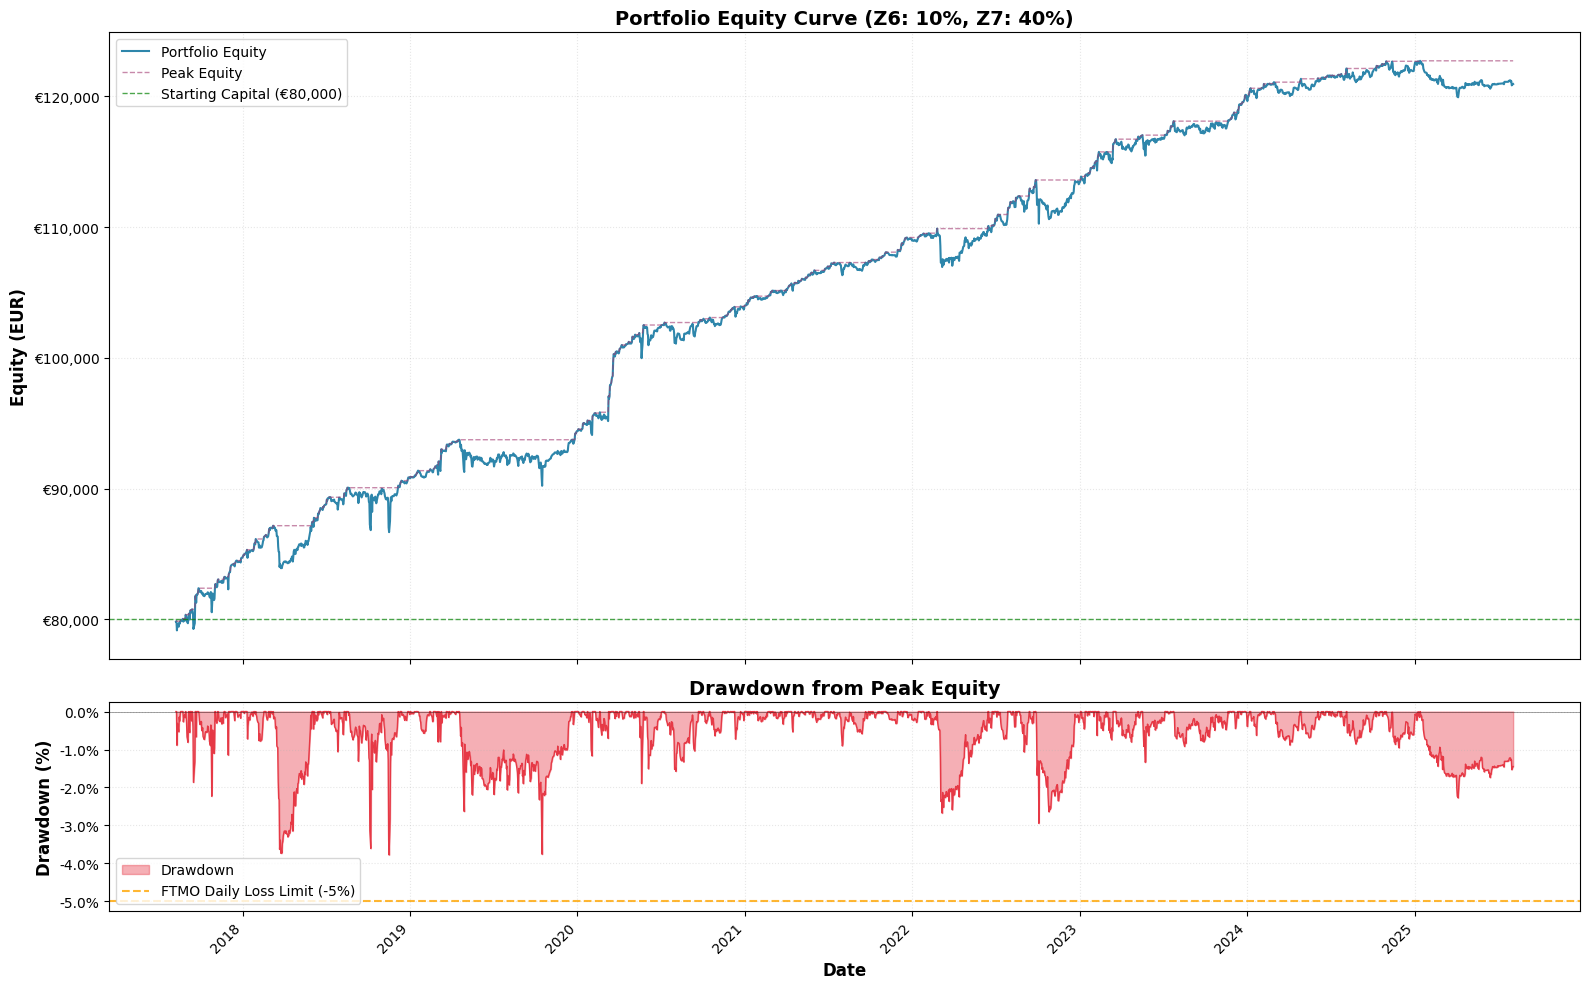

In [124]:
import matplotlib.pyplot as plt

# Create figure with two subplots with adjusted height ratios
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True, gridspec_kw={'height_ratios': [3, 1]})

# ============================================================================
# Top Plot: Portfolio Equity Curve
# ============================================================================
ax1.plot(df_aligned['Date'], df_aligned['portfolio_equity'], linewidth=1.5, color='#2E86AB', label='Portfolio Equity')
ax1.plot(df_aligned['Date'], df_aligned['portfolio_peak'], linewidth=1, color='#A23B72', linestyle='--', alpha=0.6, label='Peak Equity')
ax1.axhline(y=STARTING_CAPITAL, color='green', linestyle='--', linewidth=1, alpha=0.7, label='Starting Capital (€80,000)')

ax1.set_ylabel('Equity (EUR)', fontsize=12, fontweight='bold')
ax1.set_title(f'Portfolio Equity Curve (Z6: {WEIGHT_Z6*100:.0f}%, Z7: {WEIGHT_Z7*100:.0f}%)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, linestyle=':')
ax1.legend(loc='best', fontsize=10)
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'€{x:,.0f}'))

# ============================================================================
# Bottom Plot: Drawdown from Peak
# ============================================================================
ax2.fill_between(df_aligned['Date'], df_aligned['portfolio_drawdown'], 0, color='#E63946', alpha=0.4, label='Drawdown')
ax2.plot(df_aligned['Date'], df_aligned['portfolio_drawdown'], linewidth=1, color='#E63946')

# Add FTMO limit lines
ax2.axhline(y=-FTMO_DAILY_LOSS_LIMIT * 100, color='orange', linestyle='--', linewidth=1.5, alpha=0.8, label='FTMO Daily Loss Limit (-5%)')
#ax2.axhline(y=-FTMO_MAX_DD_LIMIT * 100, color='red', linestyle='--', linewidth=1.5, alpha=0.8, label='FTMO Max DD Limit (-10%)')
ax2.axhline(y=0, color='black', linestyle='-', linewidth=0.5, alpha=0.5)

ax2.set_xlabel('Date', fontsize=12, fontweight='bold')
ax2.set_ylabel('Drawdown (%)', fontsize=12, fontweight='bold')
ax2.set_title('Drawdown from Peak Equity', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, linestyle=':')
ax2.legend(loc='best', fontsize=10)
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}%'))

# Rotate x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()